In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing pandas
import numpy as np
import pandas as pd
from pandas.core.internals.blocks import F

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors, datasets
#from sklearn.inspection import DecisionBoundaryDisplay

import sklearn.metrics
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [ ]:
col = [4,5,6,7, 10,11,12,15]
Dos= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/preprocessing_data/DoS_dataset_pre.csv',usecols=col)
Fuzzy=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/preprocessing_data/Fuzzy_dataset_pre.csv',usecols=col)
Rpm=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/preprocessing_data/RPM_dataset_pre.csv',usecols=col)
#,usecols = col

In [ ]:
Dataset = pd.concat((Dos, Fuzzy, Rpm))

def sampling_func(data, n_sample):
    np.random.seed(10) #실행할 때마다 동일한 샘플을 추출하기 위해 random seed 고정
    N = len(data)
    sample = data.take(np.random.permutation(N)[:n_sample])
    return sample

SampledDataset = Dataset.groupby('Label', group_keys=False).apply(sampling_func, n_sample=250000)

In [ ]:
X = SampledDataset.drop(['Label'], axis=1)
y = SampledDataset['Label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 1)

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

# AutoEncoder: encoding_dim=4

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Autoencoder 클래스 정의
class Autoencoder(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim, optimizer='adam', epochs=10, batch_size=32):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None

    def fit(self, X, y=None):
        input_layer = Input(shape=(self.input_dim,))
        encoded = Dense(self.encoding_dim, activation='relu')(input_layer)
        decoded = Dense(self.input_dim, activation='sigmoid')(encoded)

        self.autoencoder = Model(inputs=input_layer, outputs=decoded)
        self.autoencoder.compile(optimizer=self.optimizer, loss='mse')

        self.autoencoder.fit(X, X, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

        return self

    def transform(self, X):
        encoder = Model(inputs=self.autoencoder.input, outputs=self.autoencoder.get_layer(index=1).output)
        encoded_X = encoder.predict(X)
        decoder_input = Input(shape=(self.encoding_dim,))
        decoded_output = self.autoencoder.layers[-1](decoder_input)  # 마지막 레이어는 디코더 레이어입니다.
        decoder = Model(inputs=decoder_input, outputs=decoded_output)
        decoded_X = decoder.predict(encoded_X)
        return decoded_X

In [ ]:
autoencoder_params = {
    'input_dim': X_train.shape[1],
    'encoding_dim': 4,
    'optimizer': 'adam',
    'epochs': 10,
    'batch_size': 32
}


In [ ]:
print(X_train.shape[1])

7


In [ ]:
# Autoencoder 모델 학습
autoencoder = Autoencoder(
    input_dim=autoencoder_params['input_dim'],
    encoding_dim=autoencoder_params['encoding_dim'],
    optimizer=autoencoder_params['optimizer'],
    epochs=autoencoder_params['epochs'],
    batch_size=autoencoder_params['batch_size']
)
autoencoder.fit(X_train)

Autoencoder(encoding_dim=4, input_dim=7)

In [ ]:
# Autoencoder를 사용하여 특징 추출
encoded_X_train = autoencoder.transform(X_train)
encoded_X_test = autoencoder.transform(X_test)

6250/6250 [==============================] - 5s 810us/step


In [ ]:
encoded_X_train

array([[4.3107057e-03, 1.0592120e-03, 1.0000000e+00, ..., 1.0000000e+00,
        6.4460311e-22, 9.6615619e-04],
       [3.2038938e-02, 1.1891702e-03, 1.7715978e-03, ..., 2.2273594e-09,
        9.9994677e-01, 9.3237730e-05],
       [9.8170346e-01, 1.0000000e+00, 1.0000000e+00, ..., 9.9999791e-01,
        1.4852586e-13, 9.8716861e-01],
       ...,
       [1.8836108e-04, 3.0484869e-05, 3.8991042e-05, ..., 5.1368470e-04,
        6.8655681e-05, 2.8189606e-05],
       [1.7769821e-04, 3.1286712e-05, 4.3189852e-05, ..., 5.2974169e-04,
        6.5935848e-05, 2.8575874e-05],
       [1.9078625e-04, 3.0325424e-05, 3.9181439e-05, ..., 5.1144749e-04,
        6.9362453e-05, 2.8154303e-05]], dtype=float32)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=5,n_estimators=50)

In [ ]:
rfc.fit(encoded_X_train, y_train)
y_pred = rfc.predict(encoded_X_test)

<Axes: >

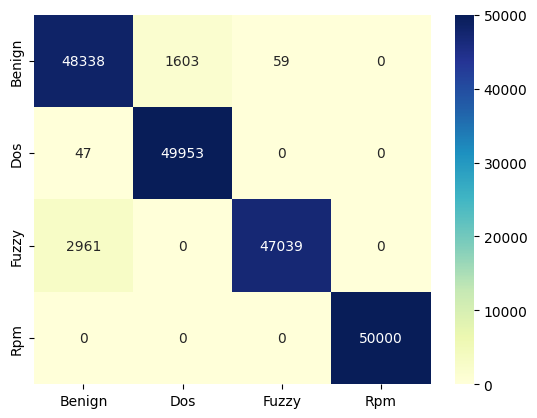

In [ ]:
import seaborn
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Benign', 'Dos', 'Fuzzy','Rpm'],
                                 index=['Benign', 'Dos', 'Fuzzy','Rpm'])

seaborn.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
#evaluation for RF


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='macro'))
print("Recall:",metrics.recall_score(y_test, y_pred, average='macro'))
print("F1_Score:",metrics.f1_score(y_test, y_pred, average='macro'))
print("Cohen_Kappa_Score:",sklearn.metrics.cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None))
#print("MSE:",metrics.mean_squared_error(Y_Test,Y_Pred_svm))

Accuracy: 0.97665
Precision: 0.977267985359461
Recall: 0.97665
F1_Score: 0.976642610653152
Cohen_Kappa_Score: 0.9688666666666667


In [ ]:
# Individual Clasification- RF

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95     50000
           1       0.97      1.00      0.98     50000
           2       1.00      0.94      0.97     50000
           3       1.00      1.00      1.00     50000

    accuracy                           0.98    200000
   macro avg       0.98      0.98      0.98    200000
weighted avg       0.98      0.98      0.98    200000



# AutoEncoder: encoding_dim=5

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Autoencoder 클래스 정의
class Autoencoder(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim, optimizer='adam', epochs=10, batch_size=32):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None

    def fit(self, X, y=None):
        input_layer = Input(shape=(self.input_dim,))
        encoded = Dense(self.encoding_dim, activation='relu')(input_layer)
        decoded = Dense(self.input_dim, activation='sigmoid')(encoded)

        self.autoencoder = Model(inputs=input_layer, outputs=decoded)
        self.autoencoder.compile(optimizer=self.optimizer, loss='mse')

        self.autoencoder.fit(X, X, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

        return self

    def transform(self, X):
        encoder = Model(inputs=self.autoencoder.input, outputs=self.autoencoder.get_layer(index=1).output)
        encoded_X = encoder.predict(X)
        decoder_input = Input(shape=(self.encoding_dim,))
        decoded_output = self.autoencoder.layers[-1](decoder_input)  # 마지막 레이어는 디코더 레이어입니다.
        decoder = Model(inputs=decoder_input, outputs=decoded_output)
        decoded_X = decoder.predict(encoded_X)
        return decoded_X

In [ ]:
autoencoder_params = {
    'input_dim': X_train.shape[1],
    'encoding_dim': 5,
    'optimizer': 'adam',
    'epochs': 10,
    'batch_size': 32
}


In [ ]:
print(X_train.shape[1])

7


In [ ]:
# Autoencoder 모델 학습
autoencoder = Autoencoder(
    input_dim=autoencoder_params['input_dim'],
    encoding_dim=autoencoder_params['encoding_dim'],
    optimizer=autoencoder_params['optimizer'],
    epochs=autoencoder_params['epochs'],
    batch_size=autoencoder_params['batch_size']
)
autoencoder.fit(X_train)

Autoencoder(encoding_dim=5, input_dim=7)

In [ ]:
# Autoencoder를 사용하여 특징 추출
encoded_X_train = autoencoder.transform(X_train)
encoded_X_test = autoencoder.transform(X_test)

6250/6250 [==============================] - 7s 1ms/step


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=5,n_estimators=50)

In [ ]:
rfc.fit(encoded_X_train, y_train)
y_pred = rfc.predict(encoded_X_test)

<Axes: >

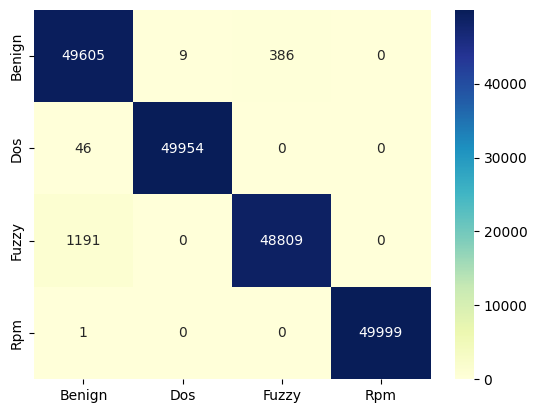

In [ ]:
import seaborn
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Benign', 'Dos', 'Fuzzy','Rpm'],
                                 index=['Benign', 'Dos', 'Fuzzy','Rpm'])

seaborn.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
#evaluation for RF


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='macro'))
print("Recall:",metrics.recall_score(y_test, y_pred, average='macro'))
print("F1_Score:",metrics.f1_score(y_test, y_pred, average='macro'))
print("Cohen_Kappa_Score:",sklearn.metrics.cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None))
#print("MSE:",metrics.mean_squared_error(Y_Test,Y_Pred_svm))

Accuracy: 0.991835
Precision: 0.9919060182213029
Recall: 0.991835
F1_Score: 0.9918370821768102
Cohen_Kappa_Score: 0.9891133333333333


In [ ]:
# Individual Clasification- RF

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     50000
           1       1.00      1.00      1.00     50000
           2       0.99      0.98      0.98     50000
           3       1.00      1.00      1.00     50000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000



<Axes: >

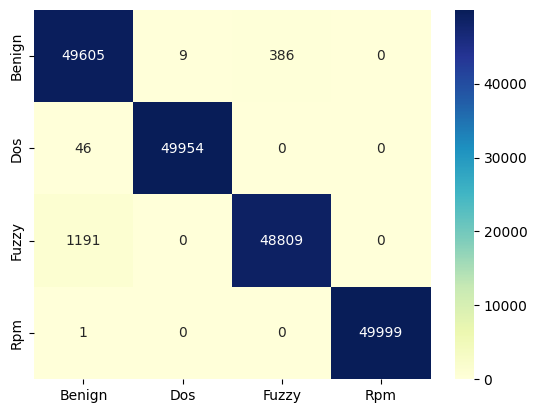

In [ ]:
import seaborn
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Benign', 'Dos', 'Fuzzy','Rpm'],
                                 index=['Benign', 'Dos', 'Fuzzy','Rpm'])

seaborn.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
#evaluation for RF

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='macro'))
print("Recall:",metrics.recall_score(y_test, y_pred, average='macro'))
print("F1_Score:",metrics.f1_score(y_test, y_pred, average='macro'))
print("Cohen_Kappa_Score:",sklearn.metrics.cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None))
#print("MSE:",metrics.mean_squared_error(Y_Test,Y_Pred_svm))

Accuracy: 0.991835
Precision: 0.9919060182213029
Recall: 0.991835
F1_Score: 0.9918370821768102
Cohen_Kappa_Score: 0.9891133333333333
